## Machine Learning Model to predict Equity StyleBox

1. We will do EDA
2. Data cleaning (attend to missing values and other)
3. We will split the data into train and validation
4. Build ML models
5. Hyper-Parameter on the best performing model
6. Build and save the final model


In [46]:
# Import all the required libraries
import pandas as pd
import janitor as jn
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas_profiling 


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
train_test_split, 
KFold, 
cross_val_score, 
GridSearchCV
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import (
AdaBoostClassifier, 
GradientBoostingClassifier, 
RandomForestClassifier, 
ExtraTreesClassifier
)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from skopt import BayesSearchCV
import numpy as np



In [47]:
# Path to the input data
file_path = '../data/funds.csv'

In [48]:
raw_data = pd.read_csv(file_path)
raw_data = jn.clean_names(raw_data)

In [49]:
raw_data.head()

name ticker  \
0          AB Sustainable Intl Thematic C  AWPCX   
1        AB Sustainable Thematic Credit A  STHAX   
2  AB Sustainable Thematic Credit Advisor  STHYX   
3      Aberdeen International Sust Ldrs A  BJBIX   
4      Aberdeen International Sust Ldrs I  JIEIX   

   morningstar_sustainability_rating  yield_%_     morningstar_category  \
0                                3.0      0.00  Global Equity Large Cap   
1                                5.0       NaN          US Fixed Income   
2                                5.0       NaN          US Fixed Income   
3                                3.0      0.54  Global Equity Large Cap   
4                                3.0      0.83  Global Equity Large Cap   

   portfolio_sustainability_score  portfolio_environmental_score  \
0                           20.67                           4.21   
1                           21.27                           3.39   
2                           21.27                           3.39   
3                           20.99                           3.31   
4                           20.99                           3.31   

   portfolio_social_score  portfolio_governance_score  \
0                    8.13                        6.92   
1                    8.11                        6.78   
2                    8.11                        6.78   
3                    8.61                        6.60   
4                    8.61                        6.60   

  sustainable_investment_by_prospectus  ... ytd_return_%_  \
0                                  Yes  ...          8.22   
1                                  Yes  ...          8.22   
2                                  Yes  ...          8.22   
3                                  Yes  ...         11.74   
4                                  Yes  ...         11.99   

  1_year_annualized_%_ 3_years_annualized_%_  5_years_annualized_%_  \
0                24.74                 19.32                  12.27   
1                24.74                 19.32                  12.27   
2                24.74                 19.32                  12.27   
3                34.20                 16.19                  11.93   
4                34.56                 16.49                  12.20   

   10_years_annualized_%_  fund_size_mil_  equity_stylebox  \
0                    7.50          941.47     Large Growth   
1                    7.50          174.22              NaN   
2                    7.50          174.22              NaN   
3                    6.09          146.06     Large Growth   
4                    6.36          146.06     Large Growth   

   fixed_income_stylebox  average_market_cap_mil_  average_credit_quality  
0                    NaN                32,187.09                     BBB  
1                    NaN                32,187.09                     BBB  
2                    NaN                32,187.09                     BBB  
3                    NaN                36,331.08                     BBB  
4                    NaN                36,331.08                     BBB  

[5 rows x 29 columns]

## Check for missing data

In [50]:
raw_data.isnull().sum()

name                                                   0
ticker                                                 1
morningstar_sustainability_rating                     10
yield_%_                                              93
morningstar_category                                   2
portfolio_sustainability_score                        10
portfolio_environmental_score                         10
portfolio_social_score                                10
portfolio_governance_score                            12
sustainable_investment_by_prospectus                   0
sustainable_investment_esg_fund                        0
sustainable_investment_impact_fund                     0
sustainable_investment_environmental_sector_fund       6
animal_testing                                         0
%_alcohol                                              0
%_fossil_fuels                                         0
%_small_arms                                           0
%_thermal_coal                 

Observations:
1. Fixed Income StyleBox has 4k missing values, so elminating this column from our analysis
2. We have few missing values for our target variable (equity_stylebox) as well we will elminate these rows since they won't help us in our ML task

In [51]:
raw_data.drop(['fixed_income_stylebox'], inplace=True, axis=1)

## Now lets look at the dataset before and after droping our NAN values

In [52]:
print(f'Dataset samples before null value elimination {len(raw_data)} \n\
Dataset samples after null value elimination {len(raw_data.dropna())}')

Dataset samples before null value elimination 6003 
Dataset samples after null value elimination 5315


## From above we see that droping NAN results in some loss of samples, but it is not that bad, so instead of any impute stratergy we will delete the rows

### Let us now define a function to futher explore missing values in table, it will return a Data Frame that will show us about the missing rows and it's stats

In [53]:
def missing_values_table(df):
    '''
    Function retreived from https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe
    '''
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

In [54]:
missing_values_table(raw_data)

Your selected dataframe has 28 columns.
There are 11 columns that have missing values.


Missing Values  \
equity_stylebox                                              598   
yield_%_                                                      93   
10_years_annualized_%_                                        38   
portfolio_governance_score                                    12   
morningstar_sustainability_rating                             10   
portfolio_sustainability_score                                10   
portfolio_environmental_score                                 10   
portfolio_social_score                                        10   
sustainable_investment_environmental_sector_fund               6   
morningstar_category                                           2   
ticker                                                         1   

                                                  % of Total Values  
equity_stylebox                                                10.0  
yield_%_                                                        1.5  
10_years_annualized_%_                                          0.6  
portfolio_governance_score                                      0.2  
morningstar_sustainability_rating                               0.2  
portfolio_sustainability_score                                  0.2  
portfolio_environmental_score                                   0.2  
portfolio_social_score                                          0.2  
sustainable_investment_environmental_sector_fund                0.1  
morningstar_category                                            0.0  
ticker                                                          0.0

## We see that the dependent column for our task has 598 missing values, we will need to eliminate those as wee

In [55]:
print(f'Dataset samples before null value elimination {len(raw_data)} \n\
Dataset samples after null value elimination {len(raw_data.dropna(subset=["equity_stylebox"]))}\n\
Dataset with still remaining null valuesDataset samples after null value elimination {(raw_data.dropna(subset=["equity_stylebox"]).isnull().sum())}')

Dataset samples before null value elimination 6003 
Dataset samples after null value elimination 5405
Dataset with still remaining null valuesDataset samples after null value elimination name                                                 0
ticker                                               1
morningstar_sustainability_rating                    2
yield_%_                                            43
morningstar_category                                 2
portfolio_sustainability_score                       2
portfolio_environmental_score                        2
portfolio_social_score                               2
portfolio_governance_score                           3
sustainable_investment_by_prospectus                 0
sustainable_investment_esg_fund                      0
sustainable_investment_impact_fund                   0
sustainable_investment_environmental_sector_fund     5
animal_testing                                       0
%_alcohol                                  

## From the data above we can eliminate all the nan values since we only loose a few hundered extra samples (we can revisit this phase and check if the data can be improved)

In [56]:
raw_data.dropna(inplace=True)
raw_data.drop(['name', 'ticker', ], axis=1, inplace=True)

In [57]:
# Columns that are categorical
cat_columns = ['morningstar_category', 'average_credit_quality', ]
# Columns that are boolean (Yes or No)
boolena_cols = ['sustainable_investment_by_prospectus', 'sustainable_investment_esg_fund', 'sustainable_investment_impact_fund', 'sustainable_investment_environmental_sector_fund']
raw_data.head().T


0  \
morningstar_sustainability_rating                                     3.0   
yield_%_                                                              0.0   
morningstar_category                              Global Equity Large Cap   
portfolio_sustainability_score                                      20.67   
portfolio_environmental_score                                        4.21   
portfolio_social_score                                               8.13   
portfolio_governance_score                                           6.92   
sustainable_investment_by_prospectus                                  Yes   
sustainable_investment_esg_fund                                       Yes   
sustainable_investment_impact_fund                                    Yes   
sustainable_investment_environmental_sector_fund                       No   
animal_testing                                                          0   
%_alcohol                                                             0.0   
%_fossil_fuels                                                       3.73   
%_small_arms                                                          0.0   
%_thermal_coal                                                        1.9   
%_tobacco                                                             0.0   
ytd_return_%_                                                        8.22   
1_year_annualized_%_                                                24.74   
3_years_annualized_%_                                               19.32   
5_years_annualized_%_                                               12.27   
10_years_annualized_%_                                                7.5   
fund_size_mil_                                                     941.47   
equity_stylebox                                              Large Growth   
average_market_cap_mil_                                         32,187.09   
average_credit_quality                                                BBB   

                                                                        3  \
morningstar_sustainability_rating                                     3.0   
yield_%_                                                             0.54   
morningstar_category                              Global Equity Large Cap   
portfolio_sustainability_score                                      20.99   
portfolio_environmental_score                                        3.31   
portfolio_social_score                                               8.61   
portfolio_governance_score                                            6.6   
sustainable_investment_by_prospectus                                  Yes   
sustainable_investment_esg_fund                                       Yes   
sustainable_investment_impact_fund                                     No   
sustainable_investment_environmental_sector_fund                       No   
animal_testing                                                          0   
%_alcohol                                                             0.0   
%_fossil_fuels                                                       2.33   
%_small_arms                                                          0.0   
%_thermal_coal                                                       2.34   
%_tobacco                                                             0.0   
ytd_return_%_                                                       11.74   
1_year_annualized_%_                                                 34.2   
3_years_annualized_%_                                               16.19   
5_years_annualized_%_                                               11.93   
10_years_annualized_%_                                               6.09   
fund_size_mil_                                                     146.06   
equity_stylebox                                              Large Growth   
average_market_cap_mil_                                         36,

## Now let us explore our target column

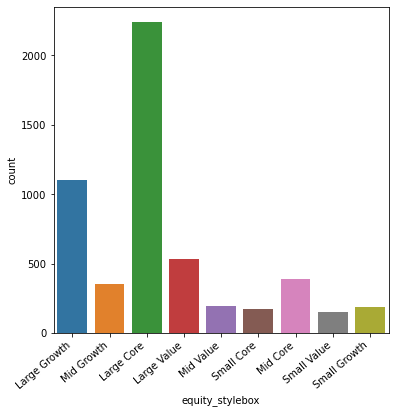

In [58]:
plt.figure(figsize=(6, 6))
ax = sns.countplot(raw_data['equity_stylebox'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

## We see that the data labels are highly skewed to be on the class "Large Core", we have a imbalanced classification task at our hand

In [59]:
raw_data[[*cat_columns, 'equity_stylebox']]

morningstar_category average_credit_quality equity_stylebox
0        Global Equity Large Cap                    BBB    Large Growth
3        Global Equity Large Cap                    BBB    Large Growth
4        Global Equity Large Cap                    BBB    Large Growth
5     US Equity Large Cap Growth                    BBB      Mid Growth
6     US Equity Large Cap Growth                    BBB      Mid Growth
...                          ...                    ...             ...
5998         Cautious Allocation                     BB      Large Core
5999         Cautious Allocation                     BB      Large Core
6000         Cautious Allocation                     BB      Large Core
6001         Cautious Allocation                     BB      Large Core
6002         Cautious Allocation                     BB      Large Core

[5315 rows x 3 columns]

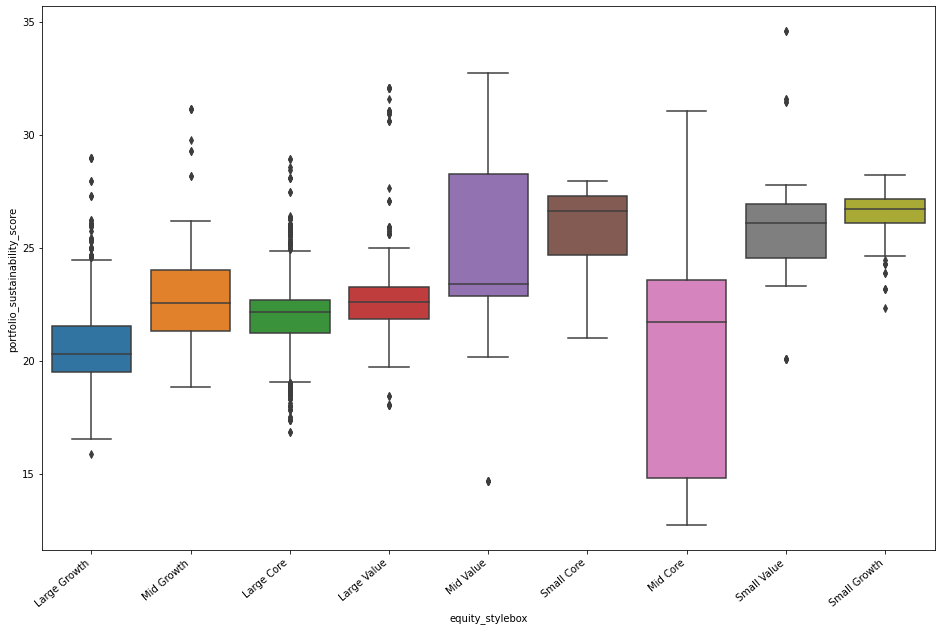

In [60]:
plt.figure(figsize=(16, 10))
ax = sns.boxplot(y='portfolio_sustainability_score', x='equity_stylebox', data=raw_data, )
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

In [61]:
raw_data.dtypes

morningstar_sustainability_rating                   float64
yield_%_                                            float64
morningstar_category                                 object
portfolio_sustainability_score                      float64
portfolio_environmental_score                       float64
portfolio_social_score                              float64
portfolio_governance_score                          float64
sustainable_investment_by_prospectus                 object
sustainable_investment_esg_fund                      object
sustainable_investment_impact_fund                   object
sustainable_investment_environmental_sector_fund     object
animal_testing                                        int64
%_alcohol                                           float64
%_fossil_fuels                                      float64
%_small_arms                                        float64
%_thermal_coal                                      float64
%_tobacco                               

## From above results we see that a few numeric rows are treated as object by pandas, this is because they have the int/float values stored as a string and contain a ",", next we will look at a function which will make the expected numeric columns to be numeric

In [62]:
def keep_only_numeric(df, cols, debug=False):
    
    '''
    This function is to eliminate any non digit characters from a column.
    This function post eliminating the non-digit characters converts the column to numeric.
    '''
    
    if debug:
        print("The data type of cols argument --->",type(cols))
        print("The contents of cols argument --->\n",(cols))
    for i in cols:
        if debug:
            print("\n\nHead of",i,"\n",df[i].head())
        df[i].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
        df[i] = pd.to_numeric(df[i])
        if debug:
            print("\n\nHead of",i,"after the update\n\n",df[i].head())
        
    return df

In [63]:
# Columns we know should be numeric
num_update_list = ['average_market_cap_mil_', 'average_credit_quality', 'fund_size_mil_']
raw_data = keep_only_numeric(raw_data, cols=num_update_list,)


## Now we should see the numeric columns must be fixed

In [64]:
raw_data.dtypes

morningstar_sustainability_rating                   float64
yield_%_                                            float64
morningstar_category                                 object
portfolio_sustainability_score                      float64
portfolio_environmental_score                       float64
portfolio_social_score                              float64
portfolio_governance_score                          float64
sustainable_investment_by_prospectus                 object
sustainable_investment_esg_fund                      object
sustainable_investment_impact_fund                   object
sustainable_investment_environmental_sector_fund     object
animal_testing                                        int64
%_alcohol                                           float64
%_fossil_fuels                                      float64
%_small_arms                                        float64
%_thermal_coal                                      float64
%_tobacco                               

## Uncomment and run the following code locally as it will consume a lot of space on github

In [65]:
#pandas_profiling.ProfileReport(raw_data)

In [66]:
#raw_data = pd.get_dummies(raw_data, drop_first=True)

In [67]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [43]:
clean_dataset(raw_data)

## Let us now take care of categorical variable by encoding them (one hot encoding) and also converting our target columns with label encoder 

In [13]:
le = LabelEncoder()

## Now let us divide our dataset 

In [68]:
validation_size = 0.2
seed = 42
X = raw_data.drop(['equity_stylebox', 'average_credit_quality'], axis=1)
Y = raw_data['equity_stylebox']
X = pd.get_dummies(X, drop_first=True)
Y  = le.fit_transform(Y)
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)


In [69]:
num_folds = 5
scoring = 'accuracy'


## We will build few models for our task

In [70]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

In [71]:
ml_accuracy = pd.DataFrame(columns = ['ml_algorithm', 'mean_accuracy', 'std_of_accuracy'])
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, )
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    temp_df = {'ml_algorithm': name, 'mean_accuracy': cv_results.mean(), 'std_of_accuracy': cv_results.std(),}
    ml_accuracy = ml_accuracy.append(temp_df, ignore_index=True)
    #print(msg)

In [72]:
def highlight_greaterthan(x):
    accuracy = 0
    if x['mean_accuracy'] > 0.95:
        return ['background-color: yellow']*3
    else:
        return ['background-color: white']*3


In [73]:
ml_accuracy.style.apply(highlight_greaterthan, axis=1)

In [74]:
for i in X_train:
    if pd.np.isnan(X_train[i]).any():
        print(i)

## Now we will optimize the hyperparameters of the RandomForest, we will use Bayesian Optimiztion to search the hyper-parameter space

In [79]:
bay_opt_rf = BayesSearchCV(
    RandomForestClassifier(random_state=42),
    {
        'n_estimators': (100, 120),
        'max_features': ['auto','sqrt'],
        'max_depth': (10, 16),
        'min_samples_split': (2,10),
        'min_samples_leaf': (1,7),
        'bootstrap': ["True","False"]
    },
    n_iter=32,
    cv=num_folds,
    scoring=scoring
)
bay_opt_rf.fit(X_train, Y_train)

print("val. score: %s" % bay_opt_rf.best_score_)

val. score: 0.9710734775696412


In [80]:
print("test score: %s" % bay_opt_rf.score(X_validation, Y_validation))

test score: 0.973659454374412


In [81]:
bay_opt_rf.best_params_

OrderedDict([('bootstrap', 'False'),
             ('max_depth', 16),
             ('max_features', 'sqrt'),
             ('min_samples_leaf', 1),
             ('min_samples_split', 2),
             ('n_estimators', 107)])

## We seem to have improved the accuracy

## Next steps are to use a different metric since it is a imbalanced classification problem